In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_validate
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("Datasets/steel.csv")
data.head()

,normalising_temperature,tempering_temperature,percent_silicon,percent_chromium,percent_copper,percent_nickel,percent_sulphur,percent_carbon,percent_manganese,tensile_strength
0,178.500,275,0.1530,0.970575,0.942,0.8870,0.0,1.920,0.0,25.107613
1,178.500,950,0.1530,1.212726,0.942,0.8870,0.0,1.920,0.0,140.035334
2,178.500,375,0.1530,1.621165,0.942,0.8870,0.0,1.920,0.0,42.217650
3,178.500,900,0.1530,0.809989,0.942,0.8870,0.0,1.920,0.0,95.015309
4,189.525,900,0.1624,1.036229,0.849,0.9382,0.0,2.035,0.0,113.266773


In [3]:
print(data.isnull().sum())

normalising_temperature    0
tempering_temperature      0
percent_silicon            0
percent_chromium           0
percent_copper             0
percent_nickel             0
percent_sulphur            0
percent_carbon             0
percent_manganese          0
tensile_strength           0
dtype: int64


In [4]:
X = data.drop(labels="tensile_strength", axis=1, inplace=False)
y = data["tensile_strength"]

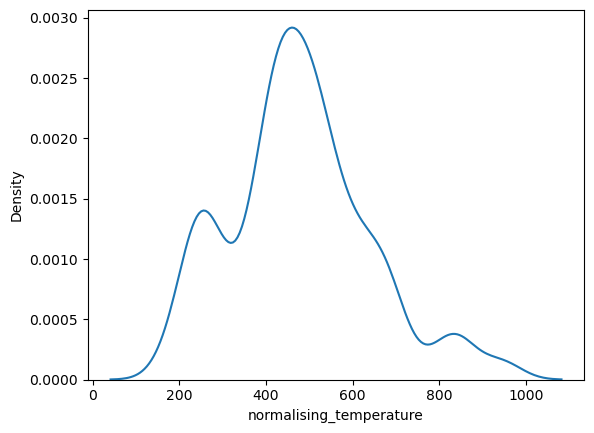

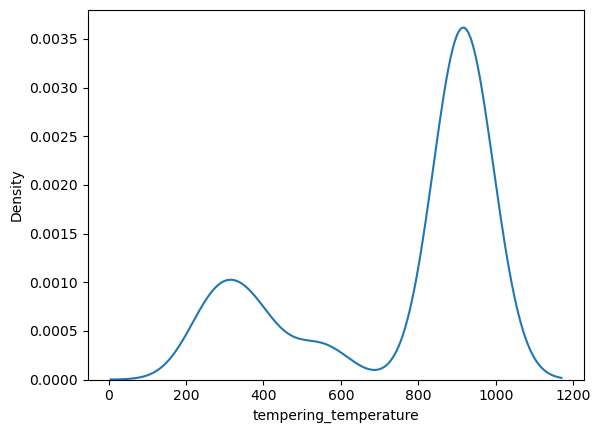

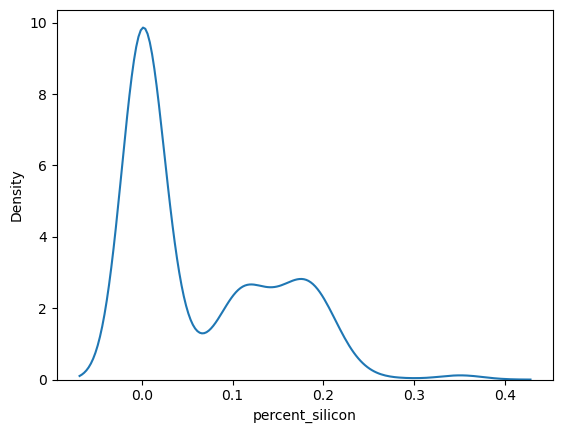

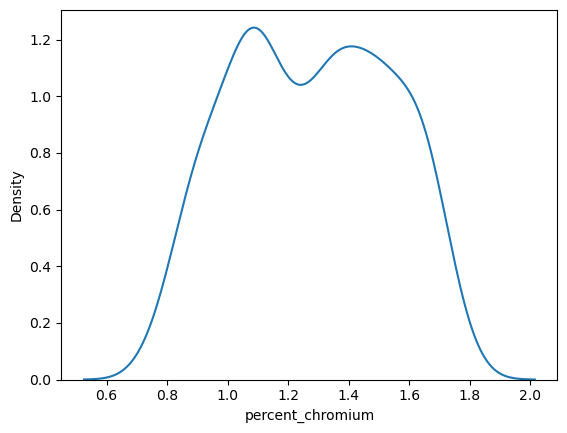

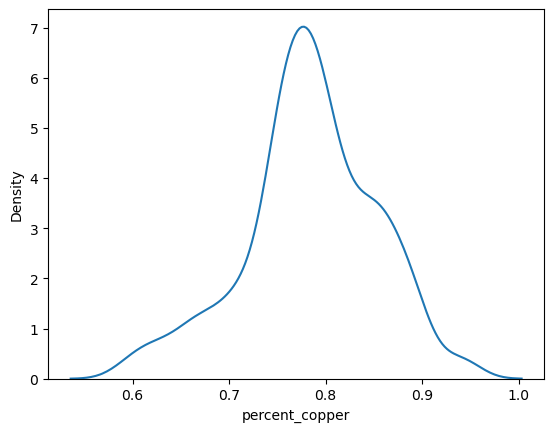

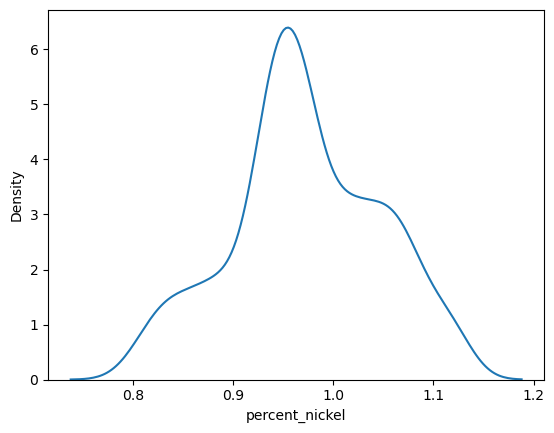

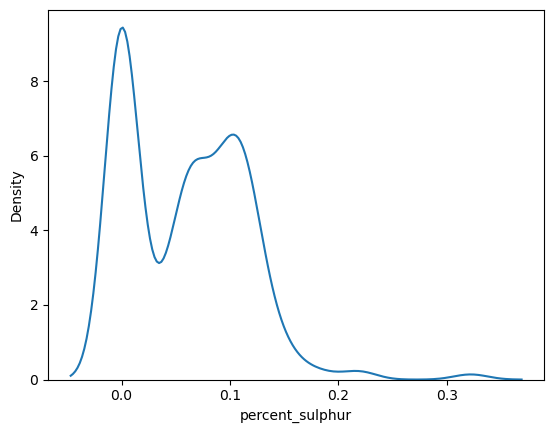

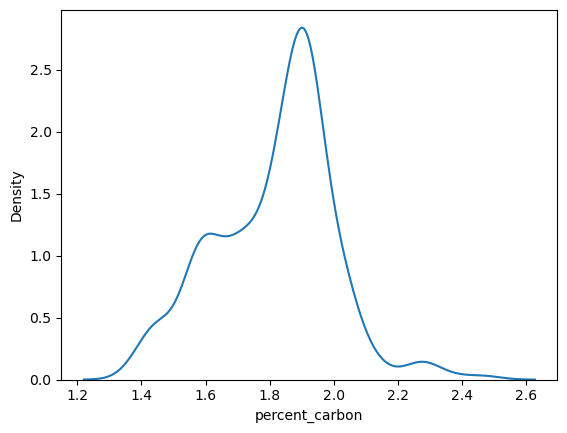

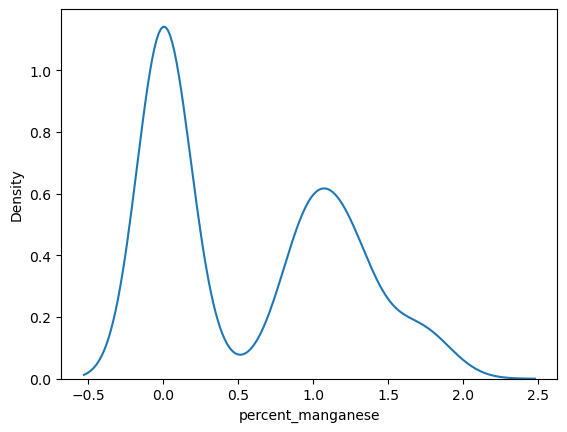

In [5]:
#graph plotting
for col in X.columns:
    sns.kdeplot(X[col])
    plt.show()

# Support Vector Regression (SVR) - Model 1

In [ ]:
#Apply train data on 10 fold cross validation on baseline model

#scale the features(X_train,X_test)
scaler = StandardScaler()
X_scale = scaler.fit_transform(X) 

cv = KFold(n_splits=10, random_state=42, shuffle=True)
model_SVR = SVR()
#applied the measurement of error 
scores = cross_validate(model_SVR,X_scale, y, scoring= {"MSE":"neg_mean_squared_error", "R2":"r2"}, 
                        cv=cv, return_train_score=True,n_jobs=-1)
results_baseline_df = pd.DataFrame(scores)

#change the neg mean square error to positive 
results_baseline_df ['test_MSE']=-results_baseline_df['test_MSE']
results_baseline_df ['train_MSE']=-results_baseline_df['train_MSE']
print(results_baseline_df)

In [7]:
results_baseline_df.describe()

,fit_time,score_time,test_MSE,train_MSE,test_R2,train_R2
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.044365,0.008747,6373.595894,6269.926813,0.234467,0.243657
std,0.055471,0.004872,2446.565107,249.324851,0.057751,0.009078
min,0.021023,0.007023,3789.577259,5840.433664,0.163308,0.231585
25%,0.021158,0.007116,4894.593875,6226.200581,0.179741,0.238647
50%,0.021206,0.007155,5703.666264,6315.316214,0.239547,0.241171
75%,0.021907,0.007315,7049.129283,6446.336899,0.274992,0.248049
max,0.193288,0.022603,10837.244186,6545.501187,0.315055,0.263662


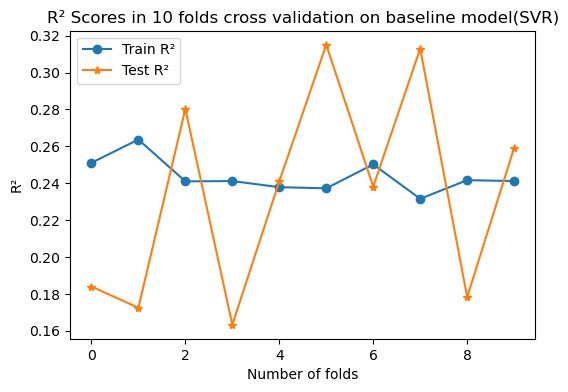

In [49]:
plt.figure(figsize=(6,4))
plt.plot(results_baseline_df["train_R2"], marker='o', label="Train R²")
plt.plot(results_baseline_df["test_R2"], marker='*', label="Test R²")
plt.legend()
plt.title("R² Scores in 10 folds cross validation on baseline model(SVR)")
plt.ylabel("R²")
plt.xlabel("Number of folds")
plt.show()

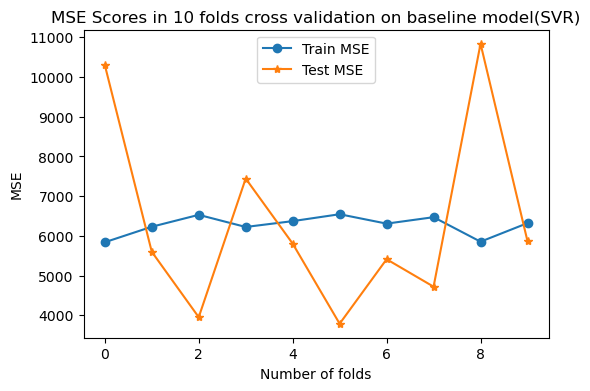

In [45]:
plt.figure(figsize=(6,4))
plt.plot(results_baseline_df["train_MSE"], marker='o', label="Train MSE")
plt.plot(results_baseline_df["test_MSE"], marker='*', label="Test MSE")
plt.title("MSE Scores in 10 folds cross validation on baseline model(SVR)")
plt.legend()
plt.ylabel("MSE")
plt.xlabel("Number of folds")
plt.show()

In [9]:
#Hyperparameter tuning
#Define paramater grid 
param_grid ={
    "kernel":["linear","sigmoid","rbf"],
    "epsilon":[0.01, 0.1, 0.5, 1.0]
}

#10 fold cross validation
gs_cv = GridSearchCV(estimator = model_SVR,
                           param_grid=param_grid,
                           scoring = {"MSE":"neg_mean_squared_error", "R2":"r2"},
                           cv=cv,
                           refit="R2",
                           return_train_score=True)

gs_cv.fit(X_scale, y)
results_finetune_df = pd.DataFrame(gs_cv.cv_results_)
#change the neg mean square error to positive 
results_finetune_df['mean_test_MSE']=-results_finetune_df['mean_test_MSE']

print("Best parameters:", gs_cv.best_params_)
print("Best score:", gs_cv.best_score_)
print(results_finetune_df[['param_kernel', 'param_epsilon', 'mean_test_MSE', 'mean_test_R2']])

Best parameters: {'epsilon': 0.5, 'kernel': 'linear'}
Best score: 0.7446809462353723
   param_kernel  param_epsilon  mean_test_MSE  mean_test_R2
0        linear           0.01    2028.638288      0.744184
1       sigmoid           0.01    4308.685657      0.476787
2           rbf           0.01    6373.285472      0.234471
3        linear           0.10    2027.067294      0.744343
4       sigmoid           0.10    4308.432681      0.476808
5           rbf           0.10    6373.595894      0.234467
6        linear           0.50    2024.299106      0.744681
7       sigmoid           0.50    4310.586830      0.476680
8           rbf           0.50    6375.946437      0.234270
9        linear           1.00    2027.512190      0.744374
10      sigmoid           1.00    4315.729704      0.475991
11          rbf           1.00    6375.992123      0.234191


# Comparison plot of baseline model vs finetune model (Support Vector Regressor)

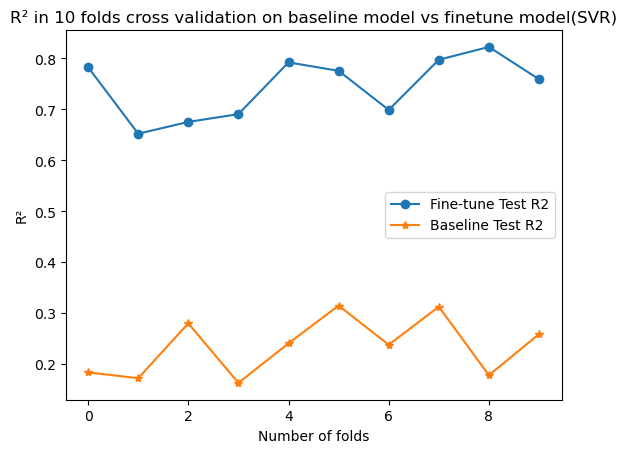

In [111]:
best_params_SVR_results = results_finetune_df.iloc[6]

best_params_SVR_results_R2_train = [best_params_SVR_results["split0_train_R2"],best_params_SVR_results["split1_train_R2"],
                                  best_params_SVR_results["split2_train_R2"],best_params_SVR_results["split3_train_R2"],
                                  best_params_SVR_results["split4_train_R2"],best_params_SVR_results["split5_train_R2"],
                                  best_params_SVR_results["split6_train_R2"],best_params_SVR_results["split7_train_R2"],
                                  best_params_SVR_results["split8_train_R2"],best_params_SVR_results["split9_train_R2"]]

best_params_SVR_results_R2 = [best_params_SVR_results["split0_test_R2"],best_params_SVR_results["split1_test_R2"],
                                  best_params_SVR_results["split2_test_R2"],best_params_SVR_results["split3_test_R2"],
                                  best_params_SVR_results["split4_test_R2"],best_params_SVR_results["split5_test_R2"],
                                  best_params_SVR_results["split6_test_R2"],best_params_SVR_results["split7_test_R2"],
                                  best_params_SVR_results["split8_test_R2"],best_params_SVR_results["split9_test_R2"]]

plt.plot(best_params_SVR_results_R2,marker='o',label="Fine-tune Test R2")
plt.plot(results_baseline_df["test_R2"], marker='*', label="Baseline Test R2")
plt.legend()
plt.title("R² in 10 folds cross validation on baseline model vs finetune model(SVR)")
plt.ylabel("R²")
plt.xlabel("Number of folds")
plt.show()

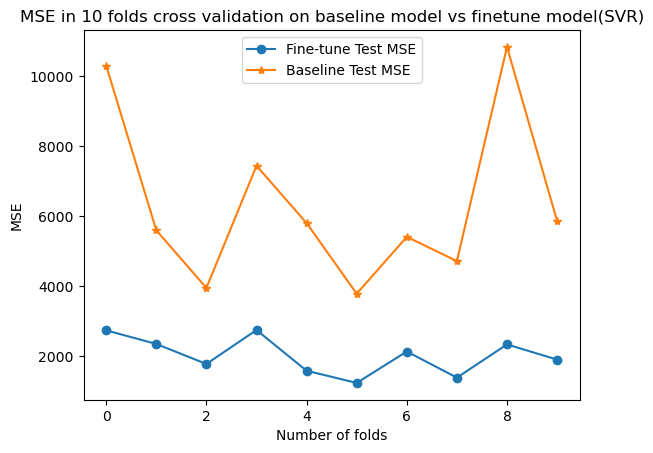

In [114]:
#conversion of neg mean square error to + mean square error
best_params_SVR_results_MSE_train = [-best_params_SVR_results["split0_train_MSE"],-best_params_SVR_results["split1_train_MSE"],
                                  -best_params_SVR_results["split2_train_MSE"],-best_params_SVR_results["split3_train_MSE"],
                                  -best_params_SVR_results["split4_train_MSE"],-best_params_SVR_results["split5_train_MSE"],
                                  -best_params_SVR_results["split6_train_MSE"],-best_params_SVR_results["split7_train_MSE"],
                                  -best_params_SVR_results["split8_train_MSE"],-best_params_SVR_results["split9_train_MSE"]]

best_params_SVR_results_MSE = [-best_params_SVR_results["split0_test_MSE"],-best_params_SVR_results["split1_test_MSE"],
                                  -best_params_SVR_results["split2_test_MSE"],-best_params_SVR_results["split3_test_MSE"],
                                  -best_params_SVR_results["split4_test_MSE"],-best_params_SVR_results["split5_test_MSE"],
                                  -best_params_SVR_results["split6_test_MSE"],-best_params_SVR_results["split7_test_MSE"],
                                  -best_params_SVR_results["split8_test_MSE"],-best_params_SVR_results["split9_test_MSE"]]

plt.plot(best_params_SVR_results_MSE,marker='o',label="Fine-tune Test MSE")
plt.plot(results_baseline_df["test_MSE"], marker='*', label="Baseline Test MSE")
plt.legend()
plt.title("MSE in 10 folds cross validation on baseline model vs finetune model(SVR)")
plt.ylabel("MSE")
plt.xlabel("Number of folds")
plt.show()

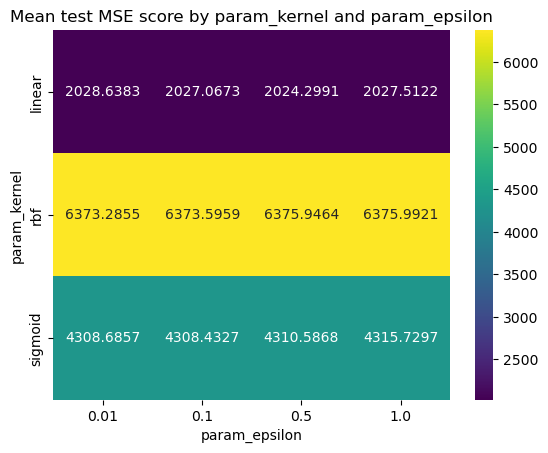

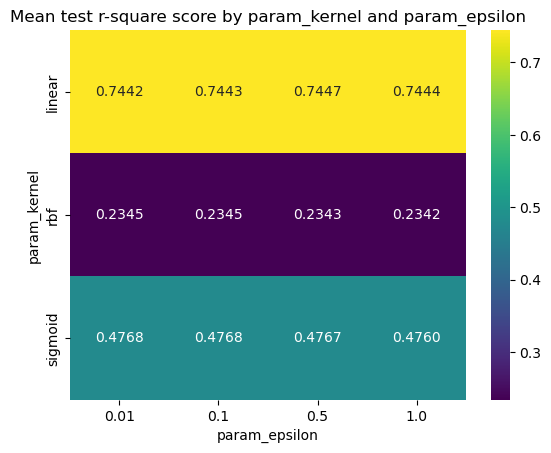

In [10]:
pivot1 = results_finetune_df.pivot(index="param_kernel", columns="param_epsilon", values="mean_test_MSE")
sns.heatmap(pivot1, annot=True, fmt=".4f",cmap="viridis")
plt.title("Mean test MSE score by param_kernel and param_epsilon")
plt.xlabel("param_epsilon")
plt.ylabel("param_kernel")
plt.show()


pivot2 = results_finetune_df.pivot(index="param_kernel", columns="param_epsilon", values="mean_test_R2")
sns.heatmap(pivot2, annot=True, fmt=".4f",cmap="viridis")
plt.title("Mean test r-square score by param_kernel and param_epsilon")
plt.xlabel("param_epsilon")
plt.ylabel("param_kernel")
plt.show()

#code reference : https://seaborn.pydata.org/generated/seaborn.heatmap.html

# K Neighbors Regressor - Model 2

In [16]:
model_KNN = KNeighborsRegressor()

scores_KNN = cross_validate(model_KNN,X_scale, y, scoring= {"MSE":"neg_mean_squared_error", "R2":"r2"}, 
                        cv=cv, return_train_score=True,n_jobs=-1)

results_baseline_df_KNN = pd.DataFrame(scores_KNN)

#change the neg mean square error to positive 
results_baseline_df_KNN ['test_MSE']=-results_baseline_df_KNN ['test_MSE']
results_baseline_df_KNN ['train_MSE']=-results_baseline_df_KNN ['train_MSE']
print(results_baseline_df_KNN)

   fit_time  score_time     test_MSE    train_MSE   test_R2  train_R2
0  0.006065    0.012836  3106.150387  1117.971975  0.754008  0.856637
1  0.003644    0.004608  1673.430694  1147.101921  0.752773  0.864431
2  0.003716    0.023948  2069.613432  1186.867452  0.623274  0.862051
3  0.016168    0.014310  1895.082317  1160.998981  0.786979  0.858469
4  0.007813    0.008225  1715.156704  1180.747183  0.775786  0.858768
5  0.005964    0.007829  1124.787896  1198.330398  0.796701  0.860354
6  0.009203    0.015591  2004.452129  1180.435940  0.717860  0.859706
7  0.006210    0.007657  1316.613627  1264.801179  0.808424  0.849813
8  0.003816    0.004783  1937.786510  1214.962249  0.853076  0.842619
9  0.005792    0.007656  1365.250774  1158.889252  0.827590  0.860892


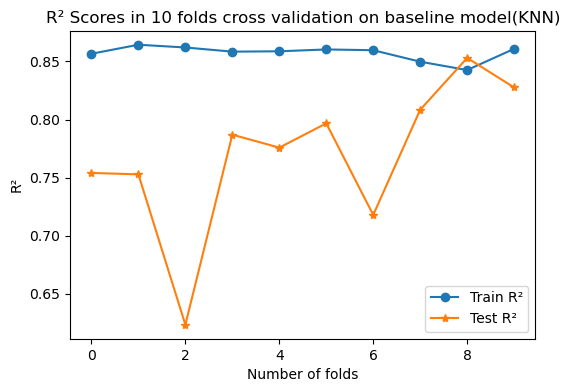

In [47]:
plt.figure(figsize=(6,4))
plt.plot(results_baseline_df_KNN["train_R2"], marker='o', label="Train R²")
plt.plot(results_baseline_df_KNN["test_R2"], marker='*', label="Test R²")
plt.title("R² Scores in 10 folds cross validation on baseline model(KNN)")
plt.legend()
plt.ylabel("R²")
plt.xlabel("Number of folds")
plt.show()

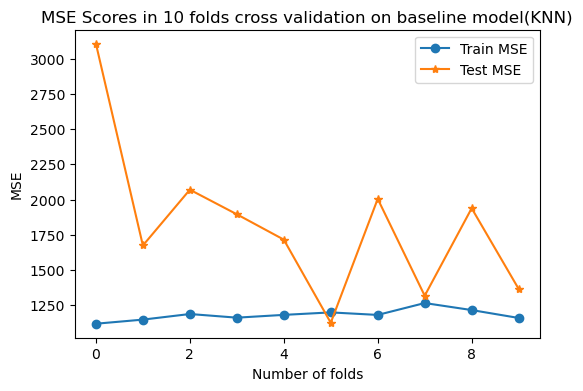

In [46]:
plt.figure(figsize=(6,4))
plt.plot(results_baseline_df_KNN["train_MSE"], marker='o', label="Train MSE")
plt.plot(results_baseline_df_KNN["test_MSE"], marker='*', label="Test MSE")
plt.title("MSE Scores in 10 folds cross validation on baseline model(KNN)")
plt.legend()
plt.ylabel("MSE")
plt.xlabel("Number of folds")
plt.show()

In [17]:
results_baseline_df_KNN.describe()

,fit_time,score_time,test_MSE,train_MSE,test_R2,train_R2
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.006839,0.010744,1820.832447,1181.110653,0.769647,0.857374
std,0.003735,0.005982,552.369201,40.168588,0.064574,0.006472
min,0.003644,0.004608,1124.787896,1117.971975,0.623274,0.842619
25%,0.004310,0.007656,1442.295754,1159.416685,0.753082,0.857095
50%,0.006014,0.008027,1805.119511,1180.591561,0.781383,0.859237
75%,0.007412,0.013941,1987.785724,1195.464661,0.805493,0.860758
max,0.016168,0.023948,3106.150387,1264.801179,0.853076,0.864431


In [18]:
n_neighbors_list = list(range(5,10))
param_grid_KNN ={
    "n_neighbors": n_neighbors_list,
    "weights":["uniform","distance"]
}

#10 fold cross validation
gs_cv_KNN = GridSearchCV(estimator = model_KNN,
                           param_grid=param_grid_KNN,
                           scoring = {"MSE":"neg_mean_squared_error", "R2":"r2"},
                           cv=cv,
                           refit="R2",
                           return_train_score=True)

gs_cv_KNN.fit(X_scale, y)
results_finetune_df_KNN = pd.DataFrame(gs_cv_KNN.cv_results_)
#change the neg mean square error to positive 
results_finetune_df_KNN['mean_test_MSE']=-results_finetune_df_KNN['mean_test_MSE']

print("Best parameters:", gs_cv_KNN.best_params_)
print("Best score:", gs_cv_KNN.best_score_)
print(results_finetune_df_KNN[['param_n_neighbors', 'param_weights', 'mean_test_MSE', 'mean_test_R2']])

Best parameters: {'n_neighbors': 6, 'weights': 'distance'}
Best score: 0.8022315484291764
   param_n_neighbors param_weights  mean_test_MSE  mean_test_R2
0                  5       uniform    1820.832447      0.769647
1                  5      distance    1577.740366      0.800818
2                  6       uniform    1834.846325      0.768919
3                  6      distance    1578.617800      0.802232
4                  7       uniform    1866.286763      0.765091
5                  7      distance    1589.418558      0.801526
6                  8       uniform    1897.337847      0.761932
7                  8      distance    1609.181678      0.799970
8                  9       uniform    1958.817340      0.754660
9                  9      distance    1647.220345      0.795240


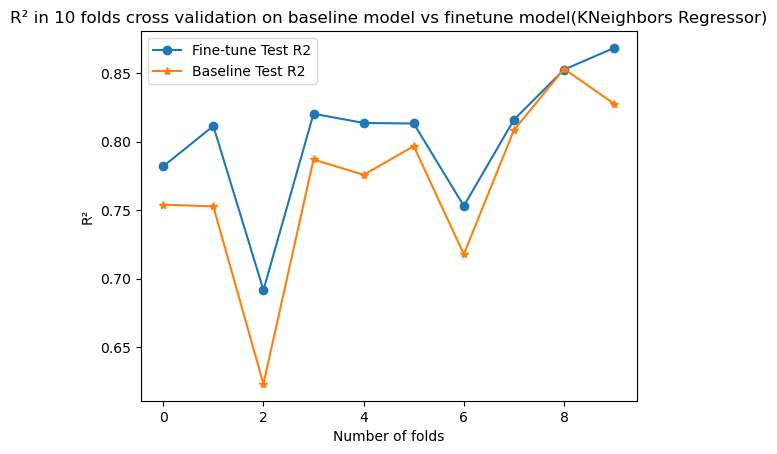

In [106]:
best_params_KNN_results = results_finetune_df_KNN.iloc[3]
best_params_KNN_results_R2_train = [best_params_KNN_results["split0_train_R2"],best_params_KNN_results["split1_train_R2"],
                                  best_params_KNN_results["split2_train_R2"],best_params_KNN_results["split3_train_R2"],
                                  best_params_KNN_results["split4_train_R2"],best_params_KNN_results["split5_train_R2"],
                                  best_params_KNN_results["split6_train_R2"],best_params_KNN_results["split7_train_R2"],
                                  best_params_KNN_results["split8_train_R2"],best_params_KNN_results["split9_train_R2"]
                                   ]
best_params_KNN_results_R2 = [best_params_KNN_results["split0_test_R2"],best_params_KNN_results["split1_test_R2"],
                                  best_params_KNN_results["split2_test_R2"],best_params_KNN_results["split3_test_R2"],
                                  best_params_KNN_results["split4_test_R2"],best_params_KNN_results["split5_test_R2"],
                                  best_params_KNN_results["split6_test_R2"],best_params_KNN_results["split7_test_R2"],
                                  best_params_KNN_results["split8_test_R2"],best_params_KNN_results["split9_test_R2"]]

plt.plot(best_params_KNN_results_R2,marker='o',label="Fine-tune Test R2")
plt.plot(results_baseline_df_KNN["test_R2"], marker='*', label="Baseline Test R2")
plt.legend()
plt.title("R² in 10 folds cross validation on baseline model vs finetune model(KNeighbors Regressor)")
plt.ylabel("R²")
plt.xlabel("Number of folds")
plt.show()


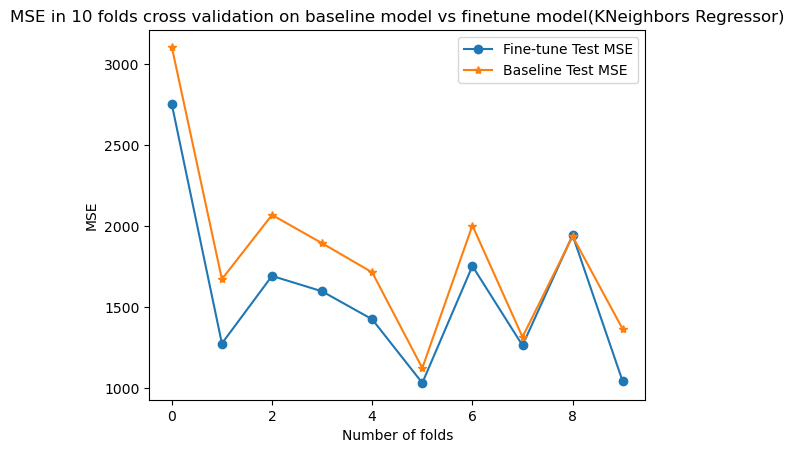

In [109]:
best_params_KNN_results_MSE_train = [-best_params_KNN_results["split0_train_MSE"],-best_params_KNN_results["split1_train_MSE"],
                                  -best_params_KNN_results["split2_train_MSE"],-best_params_KNN_results["split3_train_MSE"],
                                  -best_params_KNN_results["split4_train_MSE"],-best_params_KNN_results["split5_train_MSE"],
                                  -best_params_KNN_results["split6_train_MSE"],-best_params_KNN_results["split7_train_MSE"],
                                  -best_params_KNN_results["split8_train_MSE"],-best_params_KNN_results["split9_train_MSE"]]

best_params_KNN_results_MSE = [-best_params_KNN_results["split0_test_MSE"],-best_params_KNN_results["split1_test_MSE"],
                                  -best_params_KNN_results["split2_test_MSE"],-best_params_KNN_results["split3_test_MSE"],
                                  -best_params_KNN_results["split4_test_MSE"],-best_params_KNN_results["split5_test_MSE"],
                                  -best_params_KNN_results["split6_test_MSE"],-best_params_KNN_results["split7_test_MSE"],
                                  -best_params_KNN_results["split8_test_MSE"],-best_params_KNN_results["split9_test_MSE"]]

plt.plot(best_params_KNN_results_MSE,marker='o',label="Fine-tune Test MSE")
plt.plot(results_baseline_df_KNN["test_MSE"], marker='*', label="Baseline Test MSE")
plt.legend()
plt.title("MSE in 10 folds cross validation on baseline model vs finetune model(KNeighbors Regressor)")
plt.ylabel("MSE")
plt.xlabel("Number of folds")
plt.show()

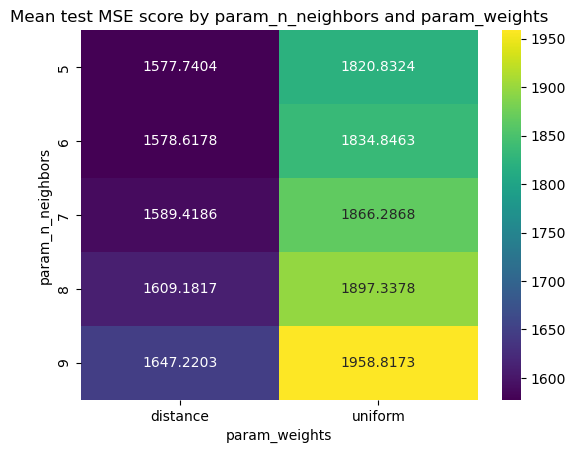

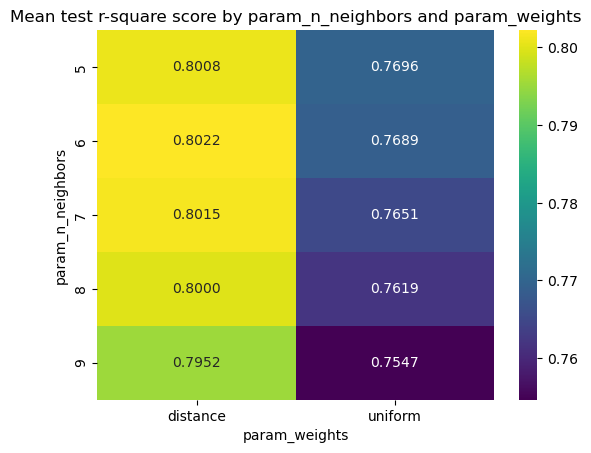

In [20]:
pivot3 = results_finetune_df_KNN.pivot(index="param_n_neighbors", columns="param_weights", values="mean_test_MSE")
sns.heatmap(pivot3, annot=True, fmt=".4f",cmap="viridis")
plt.title("Mean test MSE score by param_n_neighbors and param_weights")
plt.xlabel("param_weights")
plt.ylabel("param_n_neighbors")
plt.show()


pivot4 = results_finetune_df.pivot(index="param_n_neighbors", columns="param_weights", values="mean_test_R2")
sns.heatmap(pivot4, annot=True, fmt=".4f",cmap="viridis")
plt.title("Mean test r-square score by param_n_neighbors and param_weights")
plt.xlabel("param_weights")
plt.ylabel("param_n_neighbors")
plt.show()

#code reference : https://seaborn.pydata.org/generated/seaborn.heatmap.html

# Comparison plot between finetune model (SVR) and finetune model (KNeighbors Regressor)

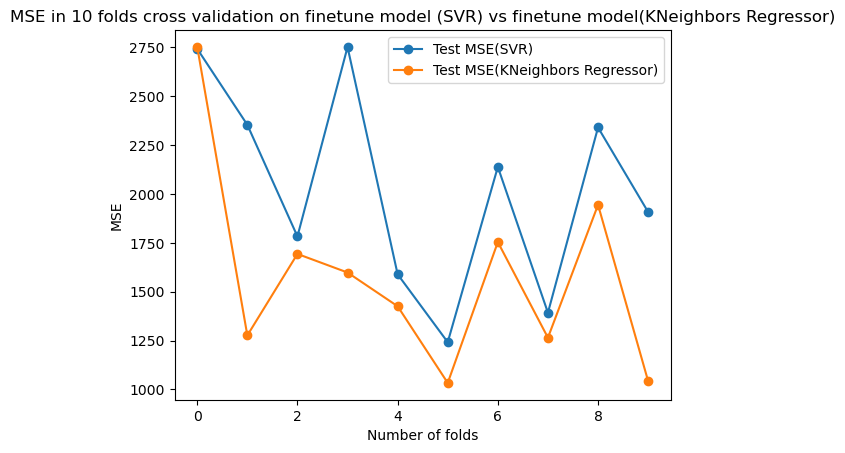

In [81]:
plt.plot(best_params_SVR_results_MSE,marker='o',label="Test MSE(SVR)")
plt.plot(best_params_KNN_results_MSE,marker='o',label="Test MSE(KNeighbors Regressor)")
plt.legend()
plt.title("MSE in 10 folds cross validation on finetune model (SVR) vs finetune model(KNeighbors Regressor)")
plt.ylabel("MSE")
plt.xlabel("Number of folds")
plt.show()

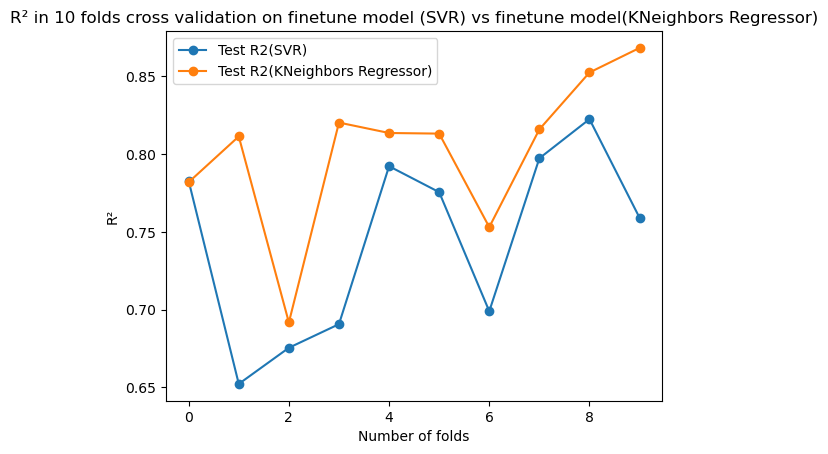

In [82]:
plt.plot(best_params_SVR_results_R2,marker='o',label="Test R2(SVR)")
plt.plot(best_params_KNN_results_R2,marker='o',label="Test R2(KNeighbors Regressor)")
plt.legend()
plt.title("R² in 10 folds cross validation on finetune model (SVR) vs finetune model(KNeighbors Regressor)")
plt.ylabel("R²")
plt.xlabel("Number of folds")
plt.show()

# Sensitive to hyperparameter tuning ? 

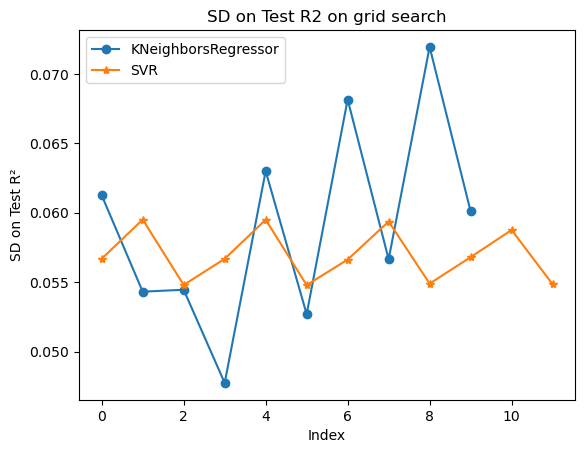

In [99]:
plt.plot(results_finetune_df_KNN["std_test_R2"],marker="o",label="KNeighborsRegressor")
plt.plot(results_finetune_df["std_test_R2"],marker="*",label="SVR")
plt.title("SD on Test R2 on grid search")
plt.legend()
plt.ylabel("SD on Test R²")
plt.xlabel("Index")
plt.show()

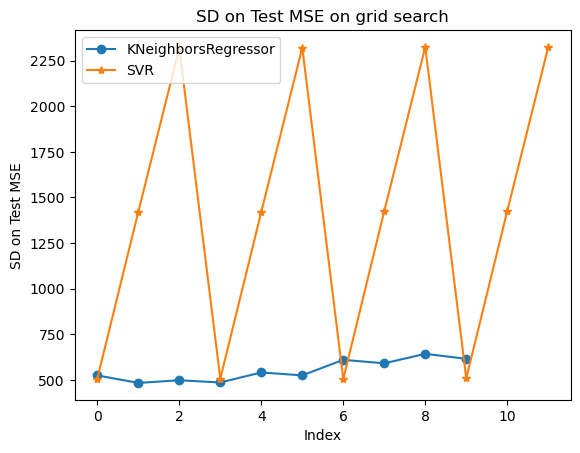

In [100]:
plt.plot(results_finetune_df_KNN["std_test_MSE"],marker="o",label="KNeighborsRegressor")
plt.plot(results_finetune_df["std_test_MSE"],marker="*",label="SVR")
plt.title("SD on Test MSE on grid search")
plt.legend()
plt.ylabel("SD on Test MSE")
plt.xlabel("Index")
plt.show()

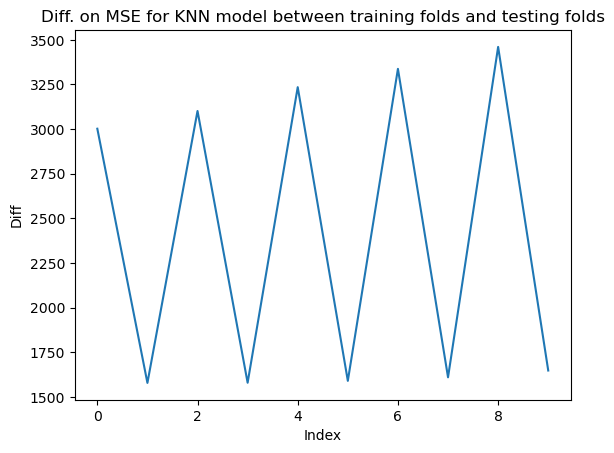

In [104]:
diff_MSE_KNN = -results_finetune_df_KNN["mean_train_MSE"]-(-results_finetune_df_KNN["mean_test_MSE"])
plt.plot(diff_MSE_KNN)
plt.title("Diff. on MSE for KNN model between training folds and testing folds")
plt.ylabel("Diff")
plt.xlabel("Index")
plt.show()

# Overfitting or underfitting?

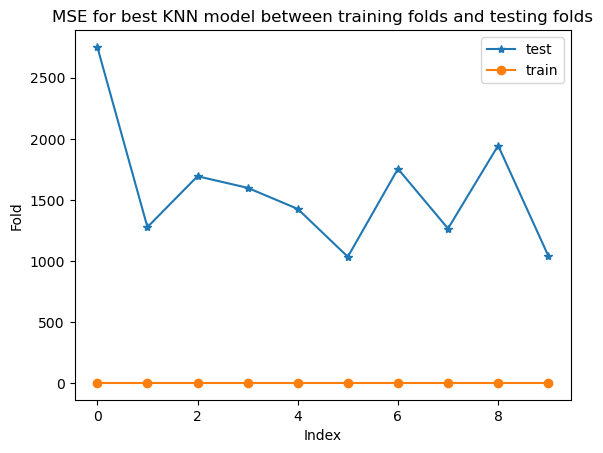

In [110]:
plt.plot(best_params_KNN_results_MSE,marker="*",label="test")
plt.plot(best_params_KNN_results_MSE_train,marker="o",label="train")
plt.legend()
plt.title("MSE for best KNN model between training folds and testing folds")
plt.ylabel("Fold")
plt.xlabel("Index")
plt.show()

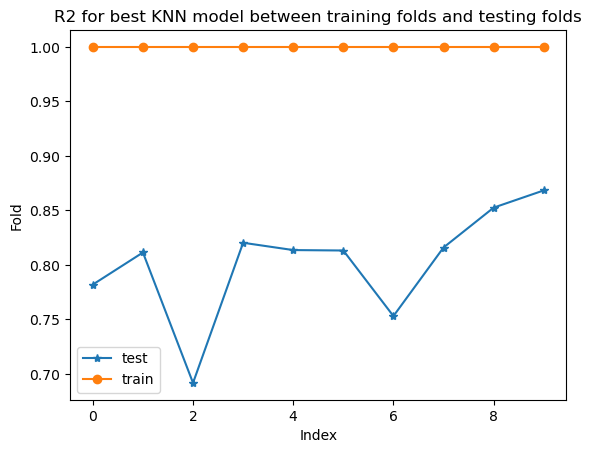

In [113]:
plt.plot(best_params_KNN_results_R2,marker="*",label="test")
plt.plot(best_params_KNN_results_R2_train,marker="o",label="train")
plt.legend()
plt.title("R2 for best KNN model between training folds and testing folds")
plt.ylabel("Fold")
plt.xlabel("Index")
plt.show()

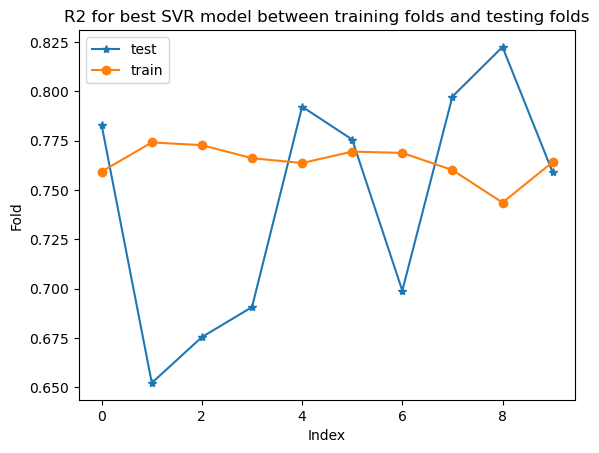

In [112]:
plt.plot(best_params_SVR_results_R2,marker="*",label="test")
plt.plot(best_params_SVR_results_R2_train,marker="o",label="train")
plt.legend()
plt.title("R2 for best SVR model between training folds and testing folds")
plt.ylabel("Fold")
plt.xlabel("Index")
plt.show()

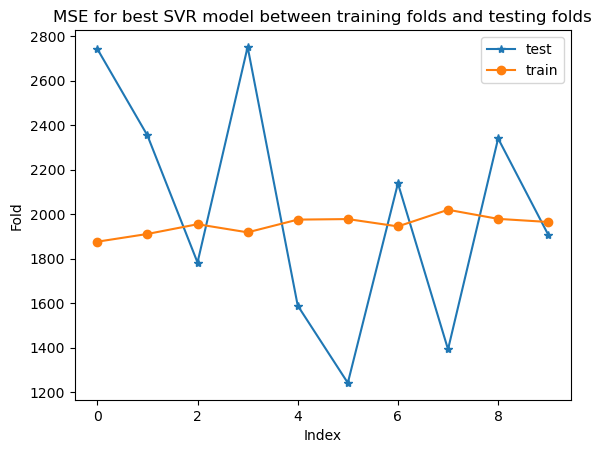

In [115]:
plt.plot(best_params_SVR_results_MSE,marker="*",label="test")
plt.plot(best_params_SVR_results_MSE_train,marker="o",label="train")
plt.legend()
plt.title("MSE for best SVR model between training folds and testing folds")
plt.ylabel("Fold")
plt.xlabel("Index")
plt.show()